## "Active Sciencing" with Reusable Workflows

By Kyle Cranmer & Lukas Heinrich June 4, 2016

Based on earlier work with NYU CDS masters students Manoj Kumar, Phil Yeres, and Michele Ceru and discussions with Brenden Lake and Gilles Louppe.

Define:

 1) $\phi$ : Experimental configuration

 2) $\theta$: Parameters that we would like to infer from the experimental data

 3) $X$ : Data generated from the experiment or simulator



In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import emcee
from scipy.stats import norm

In [32]:
#put this in a separate file
from scipy.stats import entropy


class Distribution:
    '''
    member vars
        variable names
        ranges  (for use with george)
    methods
        density estimate (KDE or histogram) (for use with emcee)
        MAP (for saddle point approximation)
        
    '''
    def __init__(self, name, range, samples=None):
        self.range = range
        self.name = name
        if samples is None:
            self.samples = np.random.uniform(range[0], range[1], size=10000)
        else:
            self.samples = samples
        
    def map(self):
        prob, edges = np.histogram(self.samples, range=self.range, bins=100)
        prob = prob.clip(min=0.0000000001)
        return edges[np.argmax(prob)]
    
    def entropy(self):
        prob, edges = np.histogram(self.samples, range=self.range, bins=100)
        prob = prob.clip(min=0.0000000001)
        return entropy(prob)
    
    def hist(self):
        prob, edges = np.histogram(self.samples, range=self.range, bins='auto')
        testVars = (edges[:-1]+edges[1:])/2
        temppdf = [self.pdf(p) for p in testVars]
        plt.plot(testVars, temppdf)
        #plt.hist(self.samples, range=self.range, bins=100)

    def pdf(self, theta):
        prob, edges = np.histogram(self.samples, range=self.range, bins=100)
        #prob = prob.clip(min=0.0000000001)
        index = edges.searchsorted(theta)

        if index > prob.size-1:
            #out of bounds
            return 0.
        return prob[index]/np.sum(prob)


## Step 1: Perform Experiment, Collect Data

In [3]:
def simulator(theta, phi, n_samples=100):
    return np.random.normal(loc=theta, scale=2 + np.sin(phi), size=n_samples)

def collect_data(phi, n_samples=100):
    # 3.141 is the unknown parameter we are trying to measure
    # best experimental setting is 3pi/2 (or any multiple of it)
    return simulator(3.141, phi, n_samples)

## Step 2: Bayesian Prior → Posterior Update 

In [4]:
def lnprior(theta, prior):
    temp = prior.pdf(theta)
    if temp == 0:
        return -np.inf
    else:
        return np.log(temp)

def lnlike(theta, y, phi):
    mean, std = theta, 2 + np.sin(phi)
    return np.log(norm(mean, std).pdf(y).prod())

def lnprob(theta, x, prior, phi):
    lp = lnprior(theta, prior)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, phi)

def calculate_posterior(prior, data, phi):
    """Compute samples from the posterior"""
    ndim, n_walkers = 1, 10
    pos = [2. + 1e-1*np.random.randn(ndim) for i in range(n_walkers)]
    
    sampler = emcee.EnsembleSampler(n_walkers, 1, lnprob, args=(data, prior, phi))
    pos, prob, state = sampler.run_mcmc(pos, 100)
    
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(pos, 300)
    
    return Distribution(prior.name, prior.range, sampler.flatchain)

In [5]:
#prior = Distribution('mean', range=(0, 2*np.pi))
#posterior = calculate_posterior(prior, data, phi)

In [6]:
#posterior.hist()

## Step 3: Optimize Experimental Configuration

Based on the updated posterior $p(\theta)$ we will consider future experiments with configuration $\phi$. For each of those configurations, we will run several simulations of the experiment and perform inference on those simulated datasets to estimate the expected information gain (EIG)

\begin{equation}
EIG(\phi) =  \int dx d\theta \; p(x | \theta) p(\theta) \big [ H\left [P(\theta) \right] - H\left[ P(\theta\, |\, x) \right] \big ] \approx \int dx  \; p(x | \theta_{MAP}) \big [ H\left [P(\theta) \right] - H\left[ P(\theta\, |\, x) \right] \big ]
\end{equation}
where
\begin{equation}
H\left [P(\theta) \right] = \int P(\theta) \log P(\theta) d\theta 
\end{equation}

To efficiently optimize $EIG[\phi]$ we will use an active learning procedure like Bayesian Optimization.

In [7]:
from scipy.stats import entropy

def info_gain(p1, p2):
    return p1.entropy() - p2.entropy()

def expected_information_gain(phi, prior):
    'calculate the expression above using workflow for simulations'
    n_simulations = 2
    
    #need to pass in prior through some extra arguments
    
    # use saddle-point approximation
    theta_map = prior.map()
    
    eig = np.zeros(n_simulations)
    
    for i_sim in range(n_simulations):
        # external workflow provides simulated data
        sim_data = simulator(theta_map, phi)

        #external workflow uses simulator to provide likelihood 
        sim_posterior = calculate_posterior(prior, sim_data, phi)
        eig[i_sim] = info_gain(prior, sim_posterior)
        
    #check for outliers?
    
    return np.mean(eig)

In [8]:
# initial phi ~ 1.456 (or so)
#phis = np.linspace(0., 2*np.pi, 20)
#eigs = [expected_information_gain(p, posterior) for p in phis]

In [9]:
#plt.plot(phis, eigs);

In [30]:
#use scikit-optimize to optimize phi
from skopt import gp_minimize
from skopt.plots import plot_objective, plot_convergence, plot_evaluations

def design_next_experiment(prior):
    bounds = [(0., 2*np.pi)]
    n_calls = 10
    
    func = lambda p: -expected_information_gain(p, prior)

    opt_result = gp_minimize(func, bounds, n_calls=n_calls, random_state=4)

    #_ = plot_evaluations(opt_result, bins=10)
    #_ = plot_objective(opt_result)
    plot_convergence(opt_result)
    return opt_result.x, opt_result.x_iters

## Run the loop

### Initialize

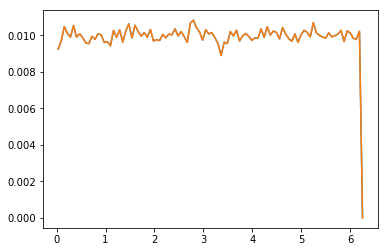

/Users/cranmer/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/cranmer/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


0 [6.0760276760949736] [[6.0760276760949736], [3.4383616276357367], [6.1115560790547407], [4.4913213487917441], [4.3839594991052548], [1.3577303436664689], [6.1341133100248433], [0.039145847961458174], [1.5895350623032367], [2.7318757680897106]]


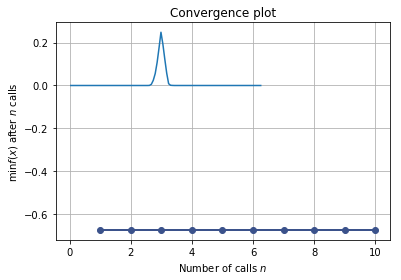

1 [4.3839594991052548] [[6.0760276760949736], [3.4383616276357367], [6.1115560790547407], [4.4913213487917441], [4.3839594991052548], [1.3577303436664689], [6.1341133100248433], [0.039145847961458174], [1.5895350623032367], [2.7318757680897106]]


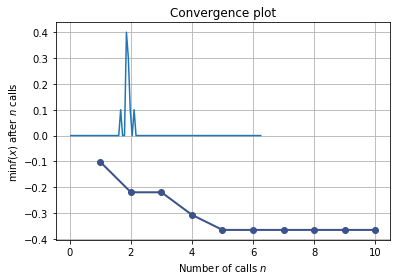

2 [1.3577303436664689] [[6.0760276760949736], [3.4383616276357367], [6.1115560790547407], [4.4913213487917441], [4.3839594991052548], [1.3577303436664689], [6.1341133100248433], [0.039145847961458174], [1.5895350623032367], [2.7318757680897106]]


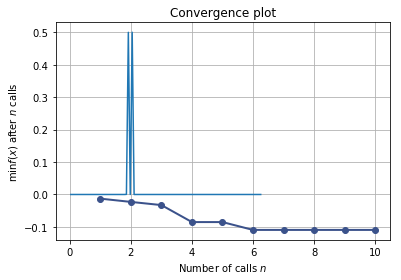

3 [0.039145847961458174] [[6.0760276760949736], [3.4383616276357367], [6.1115560790547407], [4.4913213487917441], [4.3839594991052548], [1.3577303436664689], [6.1341133100248433], [0.039145847961458174], [1.5895350623032367], [2.7318757680897106]]


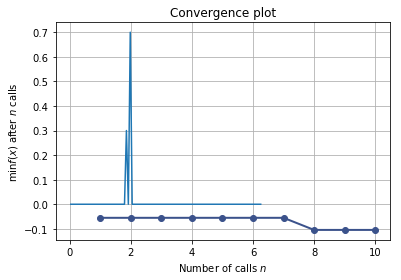

4 [6.1341133100248433] [[6.0760276760949736], [3.4383616276357367], [6.1115560790547407], [4.4913213487917441], [4.3839594991052548], [1.3577303436664689], [6.1341133100248433], [0.039145847961458174], [1.5895350623032367], [2.7318757680897106]]


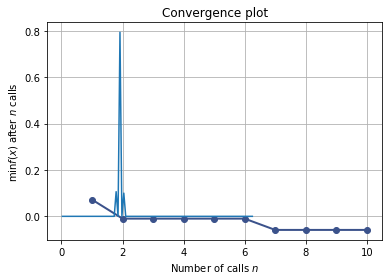

5 [6.0760276760949736] [[6.0760276760949736], [3.4383616276357367], [6.1115560790547407], [4.4913213487917441], [4.3839594991052548], [1.3577303436664689], [6.1341133100248433], [0.039145847961458174], [1.5895350623032367], [2.7318757680897106]]


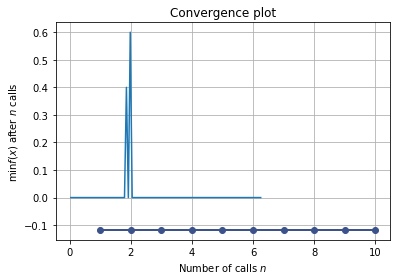

6 [2.7318757680897106] [[6.0760276760949736], [3.4383616276357367], [6.1115560790547407], [4.4913213487917441], [4.3839594991052548], [1.3577303436664689], [6.1341133100248433], [0.039145847961458174], [1.5895350623032367], [2.7318757680897106]]


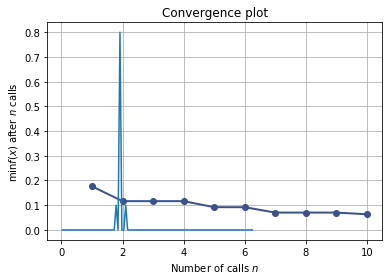

7 [3.4383616276357367] [[6.0760276760949736], [3.4383616276357367], [6.1115560790547407], [4.4913213487917441], [4.3839594991052548], [1.3577303436664689], [6.1341133100248433], [0.039145847961458174], [1.5895350623032367], [2.7318757680897106]]


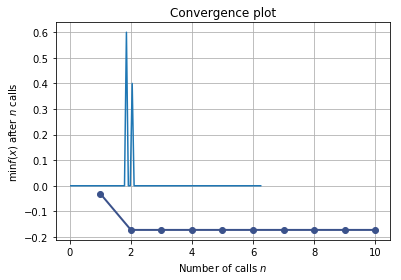

8 [2.7318757680897106] [[6.0760276760949736], [3.4383616276357367], [6.1115560790547407], [4.4913213487917441], [4.3839594991052548], [1.3577303436664689], [6.1341133100248433], [0.039145847961458174], [1.5895350623032367], [2.7318757680897106]]


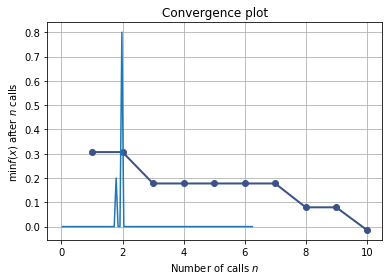

9 [4.3839594991052548] [[6.0760276760949736], [3.4383616276357367], [6.1115560790547407], [4.4913213487917441], [4.3839594991052548], [1.3577303436664689], [6.1341133100248433], [0.039145847961458174], [1.5895350623032367], [2.7318757680897106]]


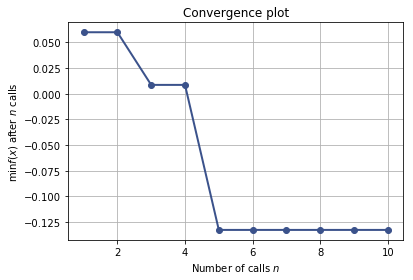

In [31]:
phi = 1.5 * np.pi

tempdata = np.random.uniform(0,2*np.pi,100000)
prior_theta = Distribution('p(theta)', range=(0,2*np.pi), samples=tempdata)
prior_theta.hist()

n_science_iterations = 10
phi_history = []
prior_history = []

for i_experiment in range(n_science_iterations):
    phi_history.append(phi)
    prior_history.append(prior_theta)
    prior_theta.hist()
    plt.show()

    # run experiment with configuration given by phi
    real_data = collect_data(phi)

    #update new prior = posterior from previous experiment
    prior_theta = calculate_posterior(prior_theta, real_data, phi)
    
    #design new experiment given current knowledge
    phi, phi_iter=design_next_experiment(prior_theta)
    print(i_experiment, phi, phi_iter)


    #plt.plot(range(i_experiment+1),phi_history)
    

#make some plots of prior, and phi 

1.2723999999999998

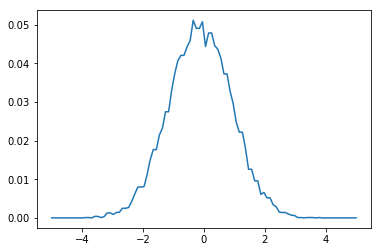

In [13]:
tempdata = np.random.normal(0,1,10000)
tempDist = Distribution('blah', range=(-5,5), samples=tempdata)
tempDist.map()
testVars = np.linspace(-5,5,100)
temppdf = [tempDist.pdf(p) for p in testVars]
plt.plot(testVars, temppdf)
np.sum(temppdf)

1.0622800000000001

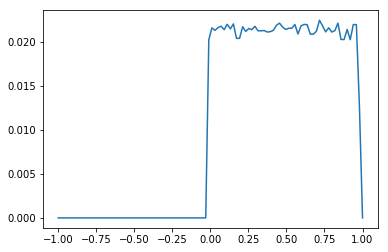

In [14]:
tempdata = np.random.uniform(0,1,100000)
tempDist = Distribution('blah', range=(-5,5), samples=tempdata)
tempDist.map()
testVars = np.linspace(-1,1,100)
temppdf = [tempDist.pdf(p) for p in testVars]
plt.plot(testVars, temppdf)
np.sum(temppdf)

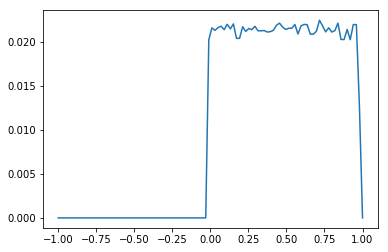

In [15]:
tempDist.hist()

In [28]:
blah=(0,1)
blah

(0, 1)

In [29]:
blah[0]

0

In [61]:
np.roll(np.linspace(0,1,101),-1)

array([ 0.01,  0.02,  0.03,  0.04,  0.05,  0.06,  0.07,  0.08,  0.09,
        0.1 ,  0.11,  0.12,  0.13,  0.14,  0.15,  0.16,  0.17,  0.18,
        0.19,  0.2 ,  0.21,  0.22,  0.23,  0.24,  0.25,  0.26,  0.27,
        0.28,  0.29,  0.3 ,  0.31,  0.32,  0.33,  0.34,  0.35,  0.36,
        0.37,  0.38,  0.39,  0.4 ,  0.41,  0.42,  0.43,  0.44,  0.45,
        0.46,  0.47,  0.48,  0.49,  0.5 ,  0.51,  0.52,  0.53,  0.54,
        0.55,  0.56,  0.57,  0.58,  0.59,  0.6 ,  0.61,  0.62,  0.63,
        0.64,  0.65,  0.66,  0.67,  0.68,  0.69,  0.7 ,  0.71,  0.72,
        0.73,  0.74,  0.75,  0.76,  0.77,  0.78,  0.79,  0.8 ,  0.81,
        0.82,  0.83,  0.84,  0.85,  0.86,  0.87,  0.88,  0.89,  0.9 ,
        0.91,  0.92,  0.93,  0.94,  0.95,  0.96,  0.97,  0.98,  0.99,
        1.  ,  0.  ])